# Task 3: Schelling model

In [3]:
%pylab inline
import pygame
from random import randint
from copy import deepcopy
from numba import njit

# the numbers according the colours
white = 0 
empty = 1
black = 2

# fill an equal amount of agents
# an amount cannot be more then 50% of fieldsize for both 2 types of agents
def fillField(agent_percent, W, H):
    # filling boundaries (if 2 types of agents, each of them can't take more than half field place)
    agents = int(agent_percent * W * H * 0.5)
    if agents >= int(W * H * 0.5):
        agents = int(W * H * 0.5)
    
    # fill current fied with empty cels
    current_field = np.ones([W+2,H+2]) * empty

    # fill field with black values
    counter1 = agents
    # while not fill all black agents
    while (counter1):
        # choose random cell
        x, y = randint(1, W), randint(1, H)
        # if this cell is empty
        if current_field[x][y] == empty:
            # we can insert black agent
            current_field[x][y] = black
            # decrease counter
            counter1 -= 1

    # fill field with white values
    counter2 = agents
    # while not fill all white agents
    while (counter2):
        # choose random cell
        x, y = randint(1, W), randint(1, H)
        # if this cell is empty
        if current_field[x][y] == empty:
            # we can insert 1 agent
            current_field[x][y] = white
            # decrease counter
            counter2 -= 1
    return current_field, agents

@njit(fastmath=True)
def check_cells(current_field, next_field, W, H, R):
    wanToMove = np.zeros((W+2,H+2)) # satus array
    wanToMove_counter = 0
    for x in range(1,W+1): # go along x axis except borders
        for y in range(1,H+1): # go along y axis except borders

            if current_field[y][x] != empty: # if not empty in current field
                num = current_field[y][x] # then get this agent type
                count = -1 # don't count self
                # count the same agents around
                for j in range(y-1,y+2):
                    for i in range(x-1,x+2):
                        # increase counter if find same agent
                        if current_field[j][i] == num:
                            count += 1
                # if an amount of agents higher than threshold
                if count >= R:
                    wanToMove[y][x] = 0 # doesn't want to move
                    # consider the same cell in the next field as cell in the current field
                    next_field[y][x] = current_field[y][x] # field won't change
                else:
                    wanToMove[y][x] = 1 # want to move
                    wanToMove_counter +=1
                    # consider the same cell in the next field as empty
                    next_field[y][x] = empty # field will change

    for x in range(1,W+1): # go along x axis except borders
        for y in range(1,H+1): # go along y axis except borders
            # if current cell want to move
            if wanToMove[y][x] == 1:
                set = 0
                # find random position y1,x1 for it on the next field, y1 != y, x1 !=x
                while set == 0:
                    y1 = randint(1, H)
                    x1 = randint(1, W)
                    # if this cell in the nexf field is empty and is not equal to current cell
                    if next_field[y1][x1] == empty: #  and y1 != y and x1 != x
                        # consider this cell in the next_field same as in the current_field
                        next_field[y1][x1] = current_field[y][x]
                        set = 1
    return next_field, wanToMove_counter

def gameOfLife(STOP_counter = 100, X_CELLS =10, Y_CELLS = 10, R = 5,
               checkPlaceToMove = True, agent_percent = 1.0, savemode = False,plot_enable = False):
    W, H = X_CELLS, Y_CELLS
    TILE = int(800 / X_CELLS)
    RES = X_CELLS * TILE, Y_CELLS * TILE
    FPS = 30
    
    # an array with the number want to move cells
    wanToMove_time=[]
    
    pygame.init()
    surface = pygame.display.set_mode(RES)
    clock = pygame.time.Clock()

    # fill zero values for all cells (empty cells)
    next_field = np.ones([W+2,H+2]) * empty
    

    # fill current field with black and white agents
    current_field, agents = fillField(agent_percent = agent_percent, W = W, H = H)
    
    
    cycle = -1
    # init as 1 to go in the cycle
    wanToMove_counter = 1
     
    # while not all iterations or there are cells willing to move
    while (STOP_counter and wanToMove_counter):
           #and wanToMove_counter):
        STOP_counter -= 1 # decrease counter in each step
        cycle +=1
        
        surface.fill(pygame.Color('grey')) # fill yhe game field
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                exit()

        # calculate the next field filling
        next_field, wanToMove_counter = check_cells(current_field, next_field, W = W, H = H, R = R) 
        wanToMove_time.append(wanToMove_counter)
        
        # put colours into each cell with according with cell's filling (number)
        for x in range(W): # go along x axis
            for y in range(H+1): # go along y axis
                # if number = white then white colour
                if (current_field[x+1][y+1] == white):
                    pygame.draw.rect(surface, pygame.Color('white'),(x * TILE + 1, y * TILE + 1, TILE - 1, TILE - 1))
                # if number = black then black colour
                if (current_field[x+1][y+1] == black):
                    pygame.draw.rect(surface, pygame.Color('black'),(x * TILE + 1, y * TILE + 1, TILE - 1, TILE - 1))

        # consider current field as the next field (it'll be previous field in the next step)
        current_field = deepcopy(next_field)
        #print(clock.get_fps())
        #print(wanToMove_counter)
        
        pygame.display.flip()
        clock.tick(FPS)
        
        if (savemode == True): 
            # print final image
            fig = plt.figure(figsize=(12, 12))
            plt.title('Time = ' + str(cycle) + '; Moving = ' + str(wanToMove_counter), fontsize=20);
            fig.suptitle('Agents location' + ' (R = ' + str(R) + ')', fontsize=30)
            plt.xlabel('X axis =' + str(W) + ' cells', fontsize=20)
            plt.ylabel('Y axis =' + str(H) + ' cells', fontsize=20)
            plt.imshow(current_field.T, cmap='Greys')
            fig.savefig('Images/' + str(R) + '/R_' + str(cycle))
            plt.close(fig)
            
        if savemode == False:
            wanToMove_counter = 1
            
    # plot final graph
    if plot_enable == True:
        plt.figure(figsize=(15, 5))
        plt.title('Time dependency of moving agents (R = ' + str(R) + ', agents = ' + str(2*agents) + ')', fontsize=20);
        plt.xlabel('Iterations', fontsize=20)
        plt.ylabel('An amount moving agents', fontsize=20)
        plt.grid()
        plot(wanToMove_time)
    
    return wanToMove_time

Populating the interactive namespace from numpy and matplotlib
pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Save all images for GIFs $ R \in [1,8]$

In [7]:
for r in range(1,9):
    gameOfLife(STOP_counter = 100, X_CELLS = 100, Y_CELLS = 100, R = r,
               checkPlaceToMove = True, agent_percent = 0.8,savemode = True, plot_enable = False)

# GIF creating

In [51]:
import glob
from PIL import Image

all_folders = []

for R in range (1,9):
    path = 'Images//'
    images = []
    all_files = []

    a = glob.glob(path + str(R) + "/*_[0-9].png")
    a.sort()
    all_files += a

    b = glob.glob(path + str(R) + "/*_[0-9][0-9].png")
    b.sort()
    all_files += b
    all_files

    c = glob.glob(path + str(R) + "/*_[0-9][0-9][0-9].png")
    c.sort()
    all_files += c
    all_folders.append(all_files)

In [54]:
for R in range (1,9):
    fp_in = all_folders[R-1]
    fp_out = 'Results//' + 'GIF_R=' + str(R) + '.gif'
    
    # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
    img, *imgs = [Image.open(f) for f in all_folders[R-1]]
    img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=int(8000/len(all_folders[R-1])), loop=0)

## Subtask 2: Plot number of households that want to move versus time for 9 values of R on one graph, label 9 curves, label the axes and title the graph

For each R game get array with an amout of agents which want to move.

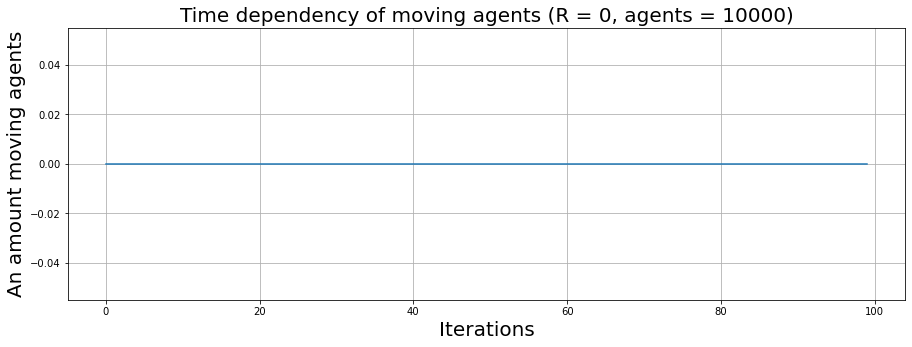

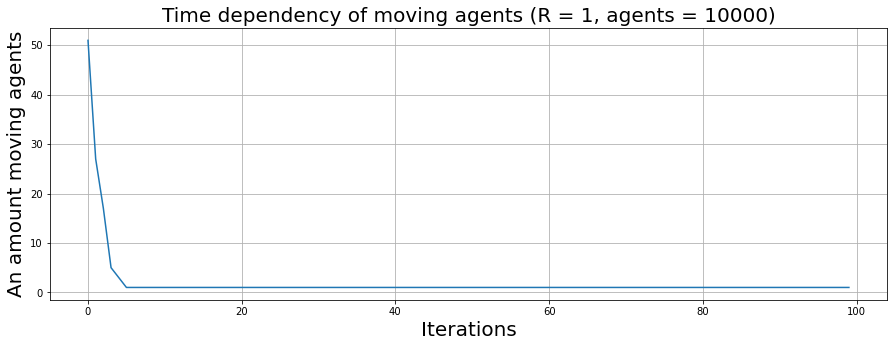

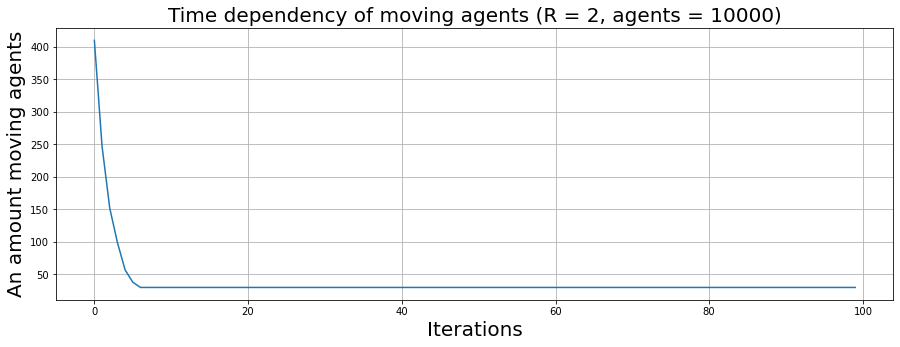

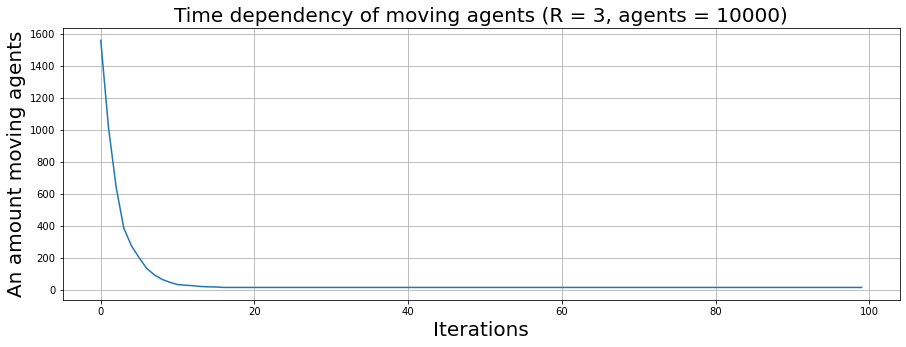

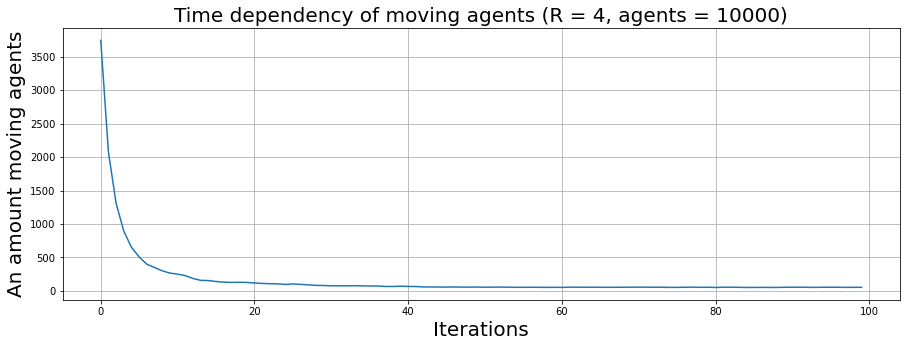

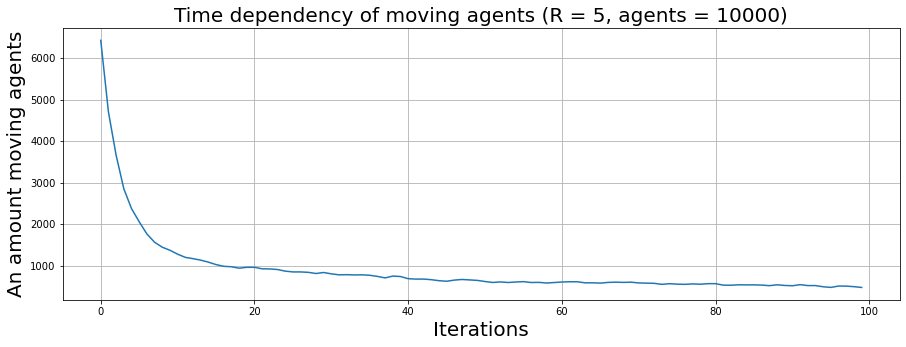

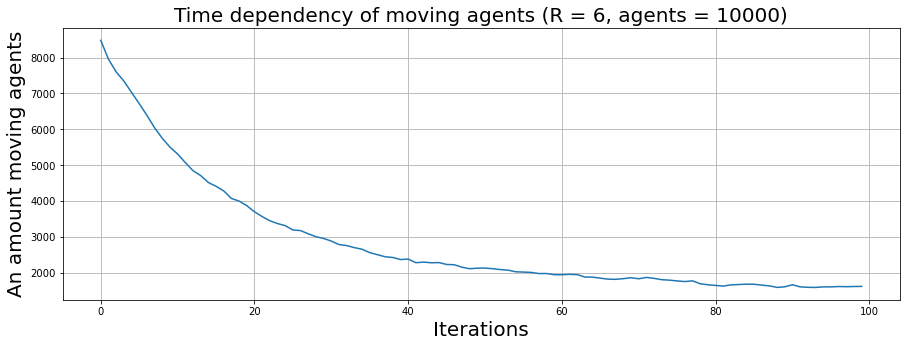

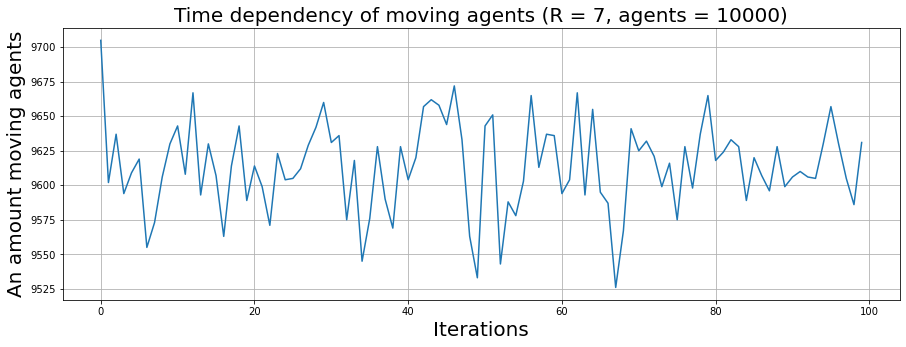

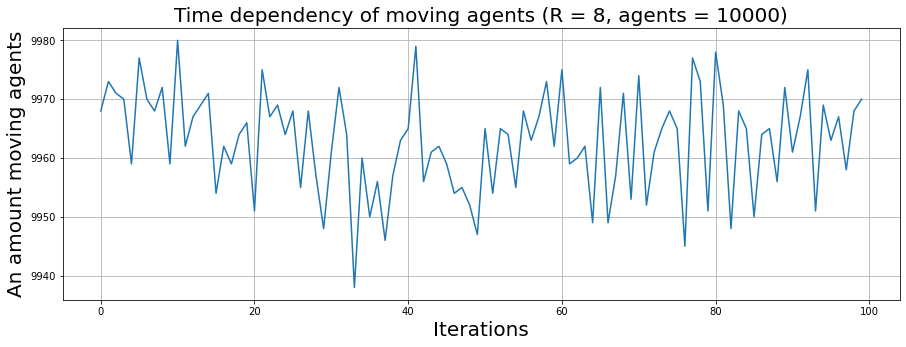

In [4]:
graph = []
for r in range(9):
    graph.append(gameOfLife(STOP_counter = 100, X_CELLS = 100, Y_CELLS = 100, R = r,
               checkPlaceToMove = True, agent_percent = 1.0,savemode = False, plot_enable = True))

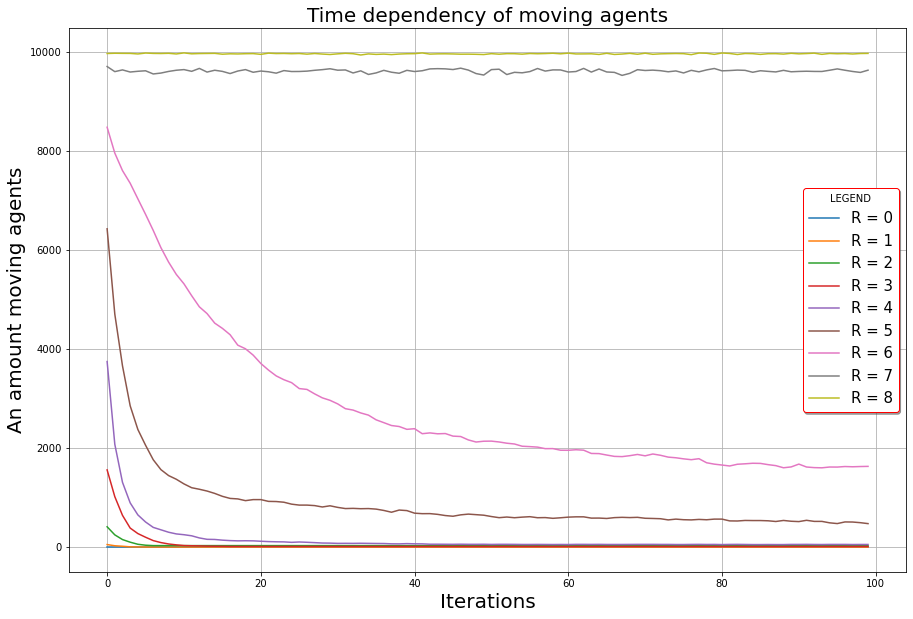

In [5]:
# Plot these dependencies on the one plane
plt.figure(figsize=(15, 10))
plt.title('Time dependency of moving agents', fontsize=20);
plt.xlabel('Iterations', fontsize=20)
plt.ylabel('An amount moving agents', fontsize=20)
plt.grid()

# plot graph for each R
for R in range(9):
    plot(graph[R][0:250],'-', label= 'R = ' + str(R), )
plt.legend(fontsize=15, shadow=True, framealpha=1, facecolor='w', edgecolor='r', title='LEGEND')

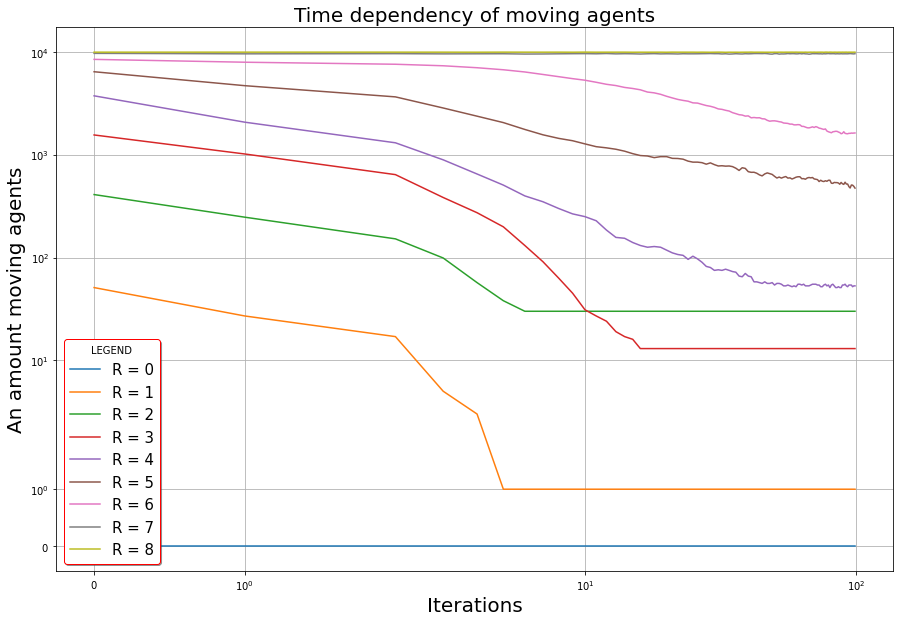

In [6]:
# Plot these dependencies on the one plane
plt.figure(figsize=(15, 10))
plt.title('Time dependency of moving agents', fontsize=20);
plt.xlabel('Iterations', fontsize=20)
plt.ylabel('An amount moving agents', fontsize=20)

# x,y scales
xscale('symlog')
yscale('symlog')
plt.grid()

# plot graph for each R
for R in range(9):
    plot(graph[R][0:250],'-', label= 'R = ' + str(R), )
plt.legend(fontsize=15, shadow=True, framealpha=1, facecolor='w', edgecolor='r', title='LEGEND')